# Cours 5 - Classification Binaire Supervisée
Camille Duquesne - TCF3 - 2022

Dans ce cours nous aborderons le sujet des métriques d'évaluations pour un projet de ML de classification binaire supervise.
Nous verrons ensuite les concepts d'underfitting et overfitting, comment les reconnaitre et comment pallier à cela.

Sources:
* https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765
* https://corporatefinanceinstitute.com/resources/data-science/overfitting/
* https://machinelearningmastery.com/overfitting-machine-learning-models/
* https://www.jeremyjordan.me/evaluating-a-machine-learning-model/
* https://neptune.ai/blog/evaluation-metrics-binary-classification
* https://thedigitalskye.com/2021/04/19/6-useful-metrics-to-evaluate-binary-classification-models/
* https://towardsdatascience.com/performance-metrics-for-binary-classifier-in-simple-words-be958535db49

---

### 1.1 Data Cleaning

Chargeons nos données :

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


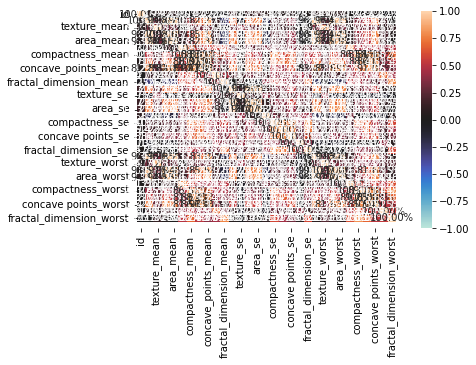

In [73]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
data = pd.read_csv('data.csv')

sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0, annot=True, fmt=".2%")

data

Tout d'abord, nous supprimons les colonnes PassengerId, Name, Cabin et Ticket car elles ne semblent pas nous fournir d'informations pertinentes.

In [74]:
# clean data
data = data.drop_duplicates()
data = data.drop(['id', 'Unnamed: 32'], axis=1)
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})
data.head()
# delete all columns except diagnosis and perimeter_mean 
data = data.drop(['radius_mean', 'texture_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'], axis=1)
# show the first 5 rows of the data
data.head()

,diagnosis,perimeter_mean
0,1,122.80
1,1,132.90
2,1,130.00
3,1,77.58
4,1,135.10


Ensuite, nous vérifions les données manquantes :

In [75]:
data.isna().sum()

diagnosis         0
perimeter_mean    0
dtype: int64

Enfin, nous voulons calculer la corrélation entre toutes nos variables pour voir si toutes les caractéristiques sont pertinentes et doivent être conservées.

<AxesSubplot:>

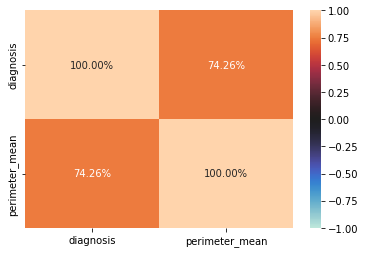

In [76]:
sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0, annot=True, fmt=".2%")

Pour tirer des enseignements de la corrélation entre les caractéristiques...
* Tarif et Pclass sont négativement corrélés (avec un coefficient de corrélation de Pearson de -0.55) ; De toute évidence, des tarifs plus élevés impliquent de meilleures classes de billets (plus le numéro de classe est bas) et vice versa.
* Pclass et survived sont modérément corrélés négativement (-0.34), ce qui implique que plus la classe de billets est bonne, plus les chances de survie sont élevées.
* Les caractéristiques SibSp et Parch sont positivement corrélées ensemble, ce qui indique le nombre de membres de la famille accompagnant le passager.
* PClass et l'âge sont négativement corrélés (-0.34), ce qui implique que plus l'âge est élevé, meilleure est la classe du billet.
* Les ports d'embarquement ont également une légère corrélation avec la survie, en particulier pour le port S (-0,16) et le port C (0,17), le port dans lequel le navire a été embarqué par les passagers a déterminé leurs chances de survie.
* Le sexe est également fortement corrélé avec la survie (-0.54), ce qui indique que le sexe du passager a un effet important sur ses chances de survie.
* Les ports d'embarquement et le tarif des passagers ont de très légères corrélations négatives, indiquant que le tarif dépend du port d'embarquement du passager.
* Embarqué et Pclass sont également légèrement corrélés, indiquant qu'un passager de 1ère classe a probablement embarqué dans un port différent de celui d'un passager de 3ème classe.

In [77]:
data

,diagnosis,perimeter_mean
0,1,122.80
1,1,132.90
2,1,130.00
3,1,77.58
4,1,135.10
...,...,...
564,1,142.00
565,1,131.20
566,1,108.30
567,1,140.10


In [78]:
y = data['diagnosis']
X = data['perimeter_mean'].to_numpy().reshape(-1, 1)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### 1.3 Entrainement du modèle

In [80]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred[:5]

# non car 2 valeurs

array([0, 1, 0, 0, 0])

In [81]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred[:5]


array([0, 1, 0, 0, 0])

In [82]:
from sklearn import tree

model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred[:5]

array([0, 1, 0, 0, 0])

In [83]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1])

### 1.4 Evaluation du modèle

Afin d'évaluer un classificateur ML binaire, quelques mesures sont à notre disposition :
* la précision
* la matrice de confusion
* Sensibilité et Spécificité
* le score F1
* la courbe ROC et l'AUC

#### 1.4.1 The Accuracy/précision

Nous allons d'abord essayer d'utiliser l'accuracy pour l'évaluation.    
Afin d'obtenir l'accuracy, nous divisons le nombre de prédictions correctes par le nombre total de prédictions et obtenons ainsi le pourcentage d'échantillons qui ont été prédits correctement :

$accuracy = \frac{CorrectPredictions}{AllPredictions}$

In [84]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.847953216374269

Cette métrique nous donne une idée très générale de l'efficacité de notre modèle. 

Mais lorsque les données sont déséquilibrées, l'accuracy n'est pas la meilleure mesure à utiliser. En effet, imaginez que un jeu de données, 95% des personnes ont survécu. Si mon modèle suppose systématiquement que les personnes ont survécu, dans le pire des cas, j'aurais donc une précision de 95 %. Ce qui semble être un excellent résultat, mais mon modèle ne ferait en fait absolument rien.

Dans les cas déséquilibrés, une "balanced accuracy" peut être calculée.

#### 1.4.2 The confusion matrix

Afin d'avoir une vision plus précise de la qualité de prédiction de notre modèle, nous pouvons utiliser la matrice de confusion.

La matrice de confusion représente donc le décompte de toutes les instances TP, TN, FP, et FN :

* Vrai Négatif (True Negative) : Chaque fois que nous disons Vrai, cela signifie que nos prédictions correspondent aux réalités. True Negative signifie que les prédictions et les réalisations sont toutes deux de classe négative.

* Vrai positif (True Positive): De même, lorsque les prédictions et les réalisations sont de classe positive, on parle de Vrai Positif.

* Faux positif (False Positive): Lorsqu'une prédiction est positive et que le réel est négatif, on parle de faux positif.

* Faux négatif (False nagative): Comme pour les faux positifs, on parle de faux négatif lorsque la prédiction est négative mais que le réel est positif. 

*Source: https://www.kdnuggets.com/2022/09/visualizing-confusion-matrix-scikitlearn.html*


<img src="ConfusionMatrix.png" alt="confusionmatrix" style="width: 600px;"/>

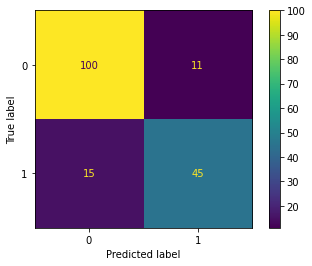

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_).plot()

#### 1.4.3 Sensitivity and Spécificity/ Sensibilité et Spécificité

À l'aide de la matrice de confusion, nous pouvons calculer des mesures plus précises pour évaluer l'efficacité de notre modèle. La précision et le rappel sont quelques-unes de ces mesures.

La sensibilité (également appelée taux de vrais positifs, TPR) est définie comme le pourcentage d'exemples pertinents (vrais positifs) parmi tous les exemples de cette classe. Vous pouvez considérer qu'il s'agit de la manière dont votre modèle étiquette précisément la classe que vous souhaitez détecter. 

La spécificité (également appelée taux de vrais négatifs, TNR), quant à elle, est définie comme le pourcentage d'exemples qui sont prédits faux parmi tous les exemples qui sont réellement faux. Vous pouvez considérer qu'il s'agit de la précision avec laquelle votre modèle identifie les classes erronées. 

La sensibilité et la spécificité sont très utiles dans les cas où les classes ne sont pas distribuées uniformément. Elles sont également très utiles si vous voulez mesurer sur quelle classe si votre modèle est très précis.

$ TPR = \frac{TP}{TP + FN}$

$ TNR = \frac{TN}{TN + FP}$

In [86]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
true_positive_rate = tp / (tp + fn)
print(true_positive_rate)

0.75


In [87]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
true_negative_rate = tn / (tn + fp)
print(true_negative_rate)

0.9009009009009009


#### 1.4.4 F1 score

Le F1 est la moyenne harmonique de Precision et Recall. Cette métrique d'évaluation est une mesure de l'exactitude globale que notre modèle a atteint dans un environnement de prédiction positive-
c'est-à-dire, parmi toutes les observations que notre modèle a étiquetées comme positives, combien de ces observations sont réellement positives. Vous utilisez cette métrique lorsque la spécificité et la sensibilité ont la même importance dans vos prédictions.

$ F1 = 2 \times \frac{TPR \times TNR}{TPR + TNR}$

In [88]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f1)

0.7758620689655172


#### 1.4.5 The ROC curve

Il s'agit d'un graphique qui permet de visualiser le compromis entre le taux de vrais positifs (TPR) et le taux de faux positifs (FPR). En fait, pour chaque seuil de décision, nous calculons le TPR et le FPR et les reportons sur un graphique.
Les courbes se situant plus en haut à gauche sont meilleurs.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


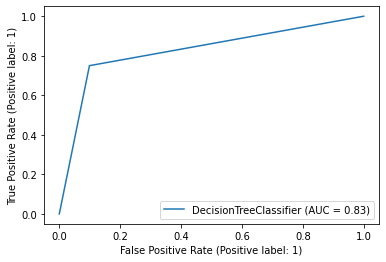

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_test, y_test)

L'objectif du tracé des courbes ROC est de pouvoir comparer la performance des modèles entre eux. Mais comparer les courbes ROC à la main peut être un peu difficile, c'est pourquoi nous utilisons une métrique appelée AUC (pour Area Under the Curve) qui calcule directement toute l'aire sous la courbe ROC. Grâce à la métrique AUC, nous pouvons comparer les modèles plus facilement. Une AUC proche de 1 est meilleure.

In [90]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred)
print(roc_auc)

0.8254504504504505


* Vous ne devriez pas l'utiliser lorsque vos données sont fortement déséquilibrées. L'intuition est la suivante : le taux de faux positifs pour les ensembles de données fortement déséquilibrés est réduit en raison d'un grand nombre de vrais négatifs.
* Vous devriez l'utiliser lorsque vous vous souciez autant des classes positives que négatives. Elle prolonge naturellement la discussion sur les données déséquilibrées de la dernière section. Si nous nous préoccupons des vrais négatifs autant que des vrais positifs, il est tout à fait logique d'utiliser ROC 

### 1.5 Your turn ! 

**C'est à votre tour d'entraîner un modèle avec l'algorithme SVM et ensuite un algorithme d'arbre de décision. Gardez le même preprocessing des données et la même répartition train-test pour chaque modèle et comparez les métriques d'évaluation que vous obtenez ! 
Quel modèle est le plus performant ? Justifiez 

## 2. Underfitting vs Overfitting 

Le but de notre algorithme d'apprentissage automatique est d'être capable de modéliser la relation entre nos caractéristiques afin de faire des prédictions précises.

Mais pour que notre modèle soit capable de "trouver notre relation globale", il est essentiel que les hyperparamètres soient bien réglés. 

En effet, si nous essayons d'avoir le meilleur modèle adapté à notre ensemble d'apprentissage, nous risquons de **sur-ajuster** le modèle. Dans ce scénario, le modèle apprendrait les données d'apprentissage "par cœur" et ne serait pas en mesure de généraliser correctement sur les données de test. 

D'autre part, si notre modèle est trop large et qu'il ne capture aucune relation, nous risquons de **underfit** notre modèle. Dans ce scénario, le modèle aura de mauvais résultats sur les données de formation ET les données de test. 

L'image suivante explique très bien ces scénarios :

<img src="model-over-fitting.png" alt="overfit_underfit" style="width: 400px;"/>

Image Source: https://www.ibm.com/cloud/learn/overfitting

Afin d'obtenir un modèle optimal, nous voulons tracer l'évolution de notre erreur de training et de notre erreur de test, en fonction de notre hyperparamètre, afin de voir où ces deux erreurs sont les plus faibles.

Pour KNN, l'hyperparamètre que nous voulons ajuster est le nombre de voisins.

[]

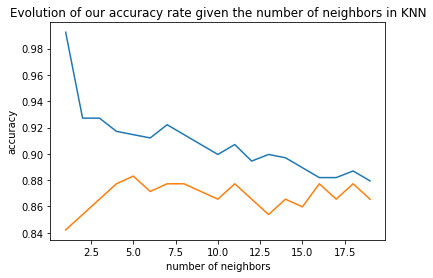

In [91]:
import matplotlib.pyplot as plt
hyperparam = [i for i in range(1,20)]
accuracy_training = []
accuracy_test = []

for k in hyperparam:
    #Training set
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    accuracy_training.append(accuracy_score(y_train, y_pred))
    #test set
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_test.append(accuracy_score(y_test, y_pred))
    
plt.plot(hyperparam, accuracy_training, label = "accuracry_training" )
plt.plot(hyperparam, accuracy_test, label = "accuracry_test" )
plt.title("Evolution of our accuracy rate given the number of neighbors in KNN")
plt.xlabel("number of neighbors")
plt.ylabel("accuracy")
plt.plot()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


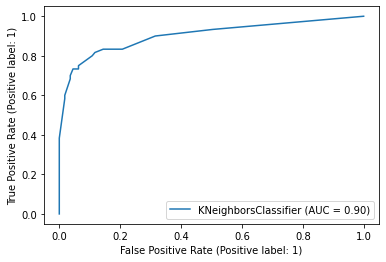

In [92]:
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_test, y_test)

Une bonne façon de réduire le risque d'overfitting lors du choix d'un modèle est d'utiliser la **k-fold-cross-validation**.

L'idée est simple : nous divisons l'ensemble d'apprentissage en un certain nombre de sous-ensembles, appelés plis. Prenons l'exemple de cinq plis. Nous effectuons une série de cycles d'apprentissage et d'évaluation où, à chaque fois, nous nous entraînons sur 4 des plis et testons le 5e, appelé l'ensemble d'attente. Nous répétons ce cycle 5 fois, en utilisant à chaque fois un pli différent pour l'évaluation. À la fin, nous faisons la moyenne des scores pour chacun des plis afin de déterminer la performance globale d'un modèle donné. Cela nous permet d'optimiser le modèle avant son déploiement sans avoir à utiliser de données supplémentaires.

<img src="CrossValidation.png" alt="cross_validation" style="width: 400px;"/>


Image Source: https://stackoverflow.com/questions/31947183/how-to-implement-walk-forward-testing-in-sklearn

In [93]:
from sklearn.model_selection import cross_val_score
model = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(model, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.84210526 0.86842105 0.88596491 0.93859649 0.92035398]
0.89 accuracy with a standard deviation of 0.03


In [94]:
from sklearn.model_selection import cross_val_score
model = SVC(kernel="linear")
scores = cross_val_score(model, X, y, cv=3)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.82105263 0.90526316 0.87301587]
0.87 accuracy with a standard deviation of 0.03


In [95]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)



Si nous dessinons notre graphique précédent en utilisant la 5-fold-cross-validation, nous obtenons :

Vous pouvez voir ici que lorsque nous utilisons la cross validation, connaitre notre nombre de voisins est moins important car les données d'entraînement sont mélangées. Donc pas de risque d'apprendre nos données d'entraînement par cœur !

Mais l'overfitting ne doit pas être confondu avec la sélection de modèle !
Nous choisissons un modèle prédictif en fonction de ses performances hors training set. C'est-à-dire, sa performance sur de nouvelles données non vues pendant la formation. Nous choisissons notre modèle en fonction de sa précision sur l'ensemble de données de test et de validation et non sur l'ensemble de données d'apprentissage.

D'autres méthodes pour éviter l'overfitting comprennent :
   *  ensembling
   * data augmentation
   * data simplification 
   
    
Lecture complémentaire : https://corporatefinanceinstitute.com/resources/data-science/overfitting/

### A votre tour ! 

**Tout en gardant le même préprocessing de données, essayez de trouver les meilleurs hyperparamètres pour un modèle SVM et un modèle d'arbre de décision (Decision Tree)**.

## 3. Pour aller plus loin

Curse of dimensionality:
 * https://medium.com/analytics-vidhya/the-curse-of-dimensionality-and-its-cure-f9891ab72e5c

Feature Selection:
* https://www.simplilearn.com/tutorials/machine-learning-tutorial/feature-selection-in-machine-learning
* https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/


In [96]:
DOC SKLEARN SUR TREE / NEIGHBORD / CVS 
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=tree
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC

SyntaxError: invalid syntax (510110234.py, line 1)